### Differential expression analysis per embryo in mesodermal subpopulations between embryonic Bmp4 KO embryos and time-matched WT embryos
see also Extended Data Figure 12c

In [1]:
setwd(here::here())

In [2]:
library("metacell")
library("tgstat")
library("Matrix")
library("dplyr")
library("ggrepel")
library("ggplot2")
library("data.table")
library("qvalue")
library("tgstat")
library("ggpubr")


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Loading required package: ggplot2


Attaching package: 'data.table'


The following objects are masked from 'package:dplyr':

    between, first, last




In [3]:
scdb_init("scrna_db_mm10_star/",force_reinit = T)

initializing scdb to scrna_db_mm10_star/



In [4]:
mc_wt_old = scdb_mc("embexe_recolored")
mc_wt = scdb_mc("mm_embexe")
mat_wt = scdb_mat("mm_embexe")
mat_all = scdb_mat('embexe_bmp4_og2_stelzer_star')
mc_all <- scdb_mc("embexe_bmp4_og2_star")

In [5]:
col_to_ct = mc_wt_old@color_key$group
names(col_to_ct) = mc_wt_old@color_key$color
ct_to_col = mc_wt_old@color_key$color
names(ct_to_col) = mc_wt_old@color_key$group

In [6]:
cmp_annot = readRDS('data/cmp_annot_embexe_bmp4.RData')
cmp_time = read.table("data/embexe_bmp4/time_match/time_match_summary.txt", header = T)
wt_age = read.table('data/embexe.transcriptional_rank_developmental_time_with_age_group.tsv',sep = '\t',h = T)

cmp_time = cmp_time  %>% left_join( wt_age %>% select(transcriptional_rank,developmental_time,age_group,morphological_stage) %>% rename(best_rank_query = transcriptional_rank))

included_colors = mc_wt_old@color_key$color[c(1:38,43:50)]
shades_blues <- colorRampPalette(RColorBrewer::brewer.pal(9,name = "Blues"))(100)

Joining, by = "best_rank_query"


In [7]:
bad_genes <- read.table('data/embexe.bad_genes.txt')[,1]
batch_genes <- read.table('data/bmp4_ko_expression_analysis_bad_genes.tsv')[,1]
batch_genes <- setdiff(batch_genes, grep("Ifitm", batch_genes, v = T))

bad_gns <- unique(c(grep("Hsp", rownames(mat_all@mat),v=T, ignore.case = T),
                            grep("BEX", rownames(mat_all@mat),v=T, ignore.case = T),
                            grep("MT", rownames(mat_all@mat),v=T, ignore.case = T),
                             grep("CDK",rownames(mat_all@mat),v=T, ignore.case = T),
                            grep("RN[0-9]", rownames(mat_all@mat),v=T, ignore.case = T),
                     grep("Nduf", rownames(mat_all@mat),v=T, ignore.case = T),
                     grep("Mrp", rownames(mat_all@mat),v=T, ignore.case = T),
                    grep("\\bcox", rownames(mat_all@mat),v=T, ignore.case = T),
                     grep("\\bRp[l|s]", rownames(mat_all@mat),v=T, ignore.case = T),
                    "Top2a", "Ube2c", "Pcna", "Mki67", "Cenpf","Hist1h1a", "Hist1h1b"))

#bad_genes <- union(bad_genes, bad_gns)
bad_genes <- union(bad_genes, batch_genes)


In [9]:
germline_ko_embryos = c("x4e26_Embryo_ExE_Bmp4_KO","x4e37_Embryo_ExE_Bmp4_KO",'x6e9_Embryo_ExE_Bmp4_KO',
                          "x4e34_Embryo_ExE_Bmp4_KO","x4e35_Embryo_ExE_Bmp4_KO")

tetraploid_ko_embryos = c('x7e14_Embryo_Bmp4_KO',
                          'x7e111_Embryo_Bmp4_KO',
                          'x7e17_Embryo_Bmp4_KO',
                          'x8e11_Embryo_Bmp4_KO',
                          'x8e23_Embryo_Bmp4_KO',
                          'x10e3_Embryo_Bmp4_KO',
                          'x10e1_Embryo_Bmp4_KO',
                          'x10e2_Embryo_Bmp4_KO',
                          'x10e9_Embryo_Bmp4_KO',
                          'x8e21_Embryo_Bmp4_KO',
                          'x8e22_Embryo_Bmp4_KO',
                          'x10e5_Embryo_Bmp4_KO',
                          'x10e7_Embryo_Bmp4_KO',
                          'x10e12_Embryo_Bmp4_KO',
                          'x10e13_Embryo_Bmp4_KO',
                          'x10e14_Embryo_Bmp4_KO',
                          'x10e16_Embryo_Bmp4_KO',
                          'x10e15_Embryo_Bmp4_KO')

tetraploid_control_embryos = c('x10c3_Embryo_Bmp4_KO','x10c5_Embryo_Bmp4_KO',
                        'x10c6_Embryo_Bmp4_KO','x10c10_Embryo_Bmp4_KO')

germline_control_embryos = c('x4e19_Embryo_ExE_Bmp4_KO','x4e22_Embryo_ExE_Bmp4_KO',
                    'x4e31_Embryo_ExE_Bmp4_KO','x6e3_Embryo_ExE_Bmp4_KO',
                    'x6e2_Embryo_ExE_Bmp4_KO','x6e1_Embryo_ExE_Bmp4_KO',
                    'x6e6_Embryo_ExE_Bmp4_KO','x6e4_Embryo_ExE_Bmp4_KO')

In [10]:
all_included_cells = names(mc_all@mc)[mc_all@colors[mc_all@mc] %in% included_colors]

wt_cells = names(mc_wt@mc)[mc_wt@colors[mc_wt@mc] %in% included_colors]
wt_cells = wt_cells[ !is.na(mat_all@cell_metadata[wt_cells,"developmental_time"])]
wt_cells = wt_cells[mat_all@cell_metadata[wt_cells,"Experiment"] != "Wildtype project"]
wt_cells = wt_cells[mat_all@cell_metadata[wt_cells,"developmental_time"] > 7.9]
wt_cells = intersect(wt_cells, names(mc_all@mc))

tetraploid_ko_cells <- rownames(mat_all@cell_metadata[names(mc_all@mc),])[mat_all@cell_metadata[names(mc_all@mc),"embryo"] %in% tetraploid_ko_embryos]
tetraploid_ko_cells <- intersect(tetraploid_ko_cells, all_included_cells)

tetraploid_ctrl_cells <- rownames(mat_all@cell_metadata[names(mc_all@mc),])[mat_all@cell_metadata[names(mc_all@mc),"embryo"] %in% tetraploid_control_embryos]
tetraploid_ctrl_cells <- intersect(tetraploid_ctrl_cells, all_included_cells)

In [11]:
egc_list_tetraploid_embryos = tapply( tetraploid_ko_cells,mat_all@cell_metadata[ tetraploid_ko_cells,"embryo"],
                                function(query_cells) {
    egc_q = t(tgs_matrix_tapply(x = mat_all@mat[,query_cells],
                         index = cmp_annot$query_cls_col[query_cells],
                         fun = sum))
                                    
    egc_q = t(t(egc_q)/colSums(egc_q))
    
    return(egc_q)
}) 

In [12]:
tetraploid_ctrl_cells <- intersect(tetraploid_ctrl_cells, names(cmp_annot$query_cls_col))

egc_list_tetraploid_ctrl_embryos = tapply( tetraploid_ctrl_cells,mat_all@cell_metadata[ tetraploid_ctrl_cells,"embryo"],
                                function(query_cells) {
    egc_q = t(tgs_matrix_tapply(x = mat_all@mat[,query_cells],
                         index = cmp_annot$query_cls_col[query_cells],
                         fun = sum))
                                    
    egc_q = t(t(egc_q)/colSums(egc_q))
    
    return(egc_q)
}) 

In [13]:
emb_ko_ct_all = table( mat_all@cell_metadata[ tetraploid_ko_cells,"embryo"],
                     factor(x = cmp_annot$query_cls_col[tetraploid_ko_cells],
                            levels = mc_wt_old@color_key$color[c(1:41,43:50)]))

tmp <- colSums(emb_ko_ct_all)
included_colors <- names(tmp[tmp > 10])

In [14]:
time_query_embryos = read.table("data/embexe_bmp4/time_match/time_match_summary.txt",sep = '\t',h = T)
time_query_embryos = time_query_embryos  %>% left_join( wt_age %>% select(transcriptional_rank,developmental_time,age_group,morphological_stage) %>% rename(best_rank_query = transcriptional_rank))
rownames(time_query_embryos) = time_query_embryos$embryo

# included_colors <- mc_wt_old@color_key$color[1:38]
wt_cells = names(mc_wt_old@mc)[mc_wt_old@colors[mc_wt_old@mc] %in% included_colors]
wt_cells = wt_cells[ !is.na(mat_all@cell_metadata[wt_cells,"developmental_time"])]
wt_cells_all = wt_cells

Joining, by = "best_rank_query"


In [15]:
roll_window = 6

cmp_matched_tetraploid_egc = lapply( tetraploid_ko_embryos,function(query_embryo) {

    matched_wt_rank = time_query_embryos[ query_embryo,'best_rank_query']
    
    matched_wt_cells = intersect(wt_cells,names(mc_all@mc))
    matched_wt_cells = matched_wt_cells [mat_all@cell_metadata[matched_wt_cells ,"transcriptional_rank"] %in% c((matched_wt_rank - roll_window):(matched_wt_rank + roll_window))]
    
    n_cells_per_cell_type = table( factor(x = col_to_ct[ mc_all@colors[ mc_all@mc[matched_wt_cells]]],levels = col_to_ct))
    
    matched_egc_wt = t(tgs_matrix_tapply(x = mat_all@mat[,matched_wt_cells],
                         index = mc_all@colors[mc_all@mc[matched_wt_cells]],
                         fun = sum))
    
    matched_egc_wt = t(t(matched_egc_wt)/colSums(matched_egc_wt))
    
    return(list("matched_egc_wt" = matched_egc_wt,
                "matched_wt_cells" = matched_wt_cells,
                "n_cells_per_cell_type" = n_cells_per_cell_type))
})

names(cmp_matched_tetraploid_egc) = tetraploid_ko_embryos

In [16]:
cmp_matched_control_egc = lapply( tetraploid_control_embryos,function(query_embryo) {

    matched_wt_rank = time_query_embryos[ query_embryo,'best_rank_query']
    
    matched_wt_cells = intersect(wt_cells,names(mc_all@mc))
    matched_wt_cells = matched_wt_cells [mat_all@cell_metadata[matched_wt_cells ,"transcriptional_rank"] %in% c((matched_wt_rank - roll_window):(matched_wt_rank + roll_window))]
    
    n_cells_per_cell_type = table( factor(x = col_to_ct[ mc_all@colors[ mc_all@mc[matched_wt_cells]]],levels = col_to_ct))
    
    matched_egc_wt = t(tgs_matrix_tapply(x = mat_all@mat[,matched_wt_cells],
                         index = mc_all@colors[mc_all@mc[matched_wt_cells]],
                         fun = sum))
    
    matched_egc_wt = t(t(matched_egc_wt)/colSums(matched_egc_wt))
    
    return(list("matched_egc_wt" = matched_egc_wt,
                "matched_wt_cells" = matched_wt_cells,
                "n_cells_per_cell_type" = n_cells_per_cell_type))
})

names(cmp_matched_control_egc) = tetraploid_control_embryos

In [17]:
tetraploid_control_ct = table( mat_all@cell_metadata[ tetraploid_ctrl_cells,"embryo"],
                       factor(x = col_to_ct[ cmp_annot$query_cls_col[tetraploid_ctrl_cells]], 
                              levels = col_to_ct))

tetraploid_ko_ct = table( mat_all@cell_metadata[ tetraploid_ko_cells,"embryo"],
                       factor(x =col_to_ct[ cmp_annot$query_cls_col[tetraploid_ko_cells]], 
                              levels = col_to_ct))

In [18]:
min_number_of_query_cells_per_cell_type = 10
reg = 5e-5

vector_of_selected_cell_types = c("Early nascent mesoderm","ExE mesoderm","Allantois")
#vector_of_selected_cell_types = c("Early nascent mesoderm","ExE mesoderm")

lfc_selected_tetraploid_list = list()
egc_query_selected_tetraploid_list = list()
egc_matched_wt_selected_tetraploid_list = list()

vector_of_tetraploid_ko_embryos = c()

for (selected_cell_type in vector_of_selected_cell_types) {
    selected_query_embryos = rownames(tetraploid_ko_ct)[tetraploid_ko_ct[,selected_cell_type] >= min_number_of_query_cells_per_cell_type]

    selected_cell_type <- array(ct_to_col[selected_cell_type])
    
    selected_query_embryos = selected_query_embryos[order( time_query_embryos[selected_query_embryos,"best_rank_query"])]
    vector_of_tetraploid_ko_embryos = c(vector_of_tetraploid_ko_embryos,selected_query_embryos)

    selected_egcs = lapply(cmp_matched_tetraploid_egc[selected_query_embryos],function(cmp) {
        return(cmp$matched_egc_wt[,selected_cell_type])
    })

    egc_wt_matched_selected = do.call(what = cbind,args = selected_egcs)
    
    egc_query_selected = lapply(egc_list_tetraploid_embryos[selected_query_embryos],function(mat_egc) {
        return(mat_egc[,selected_cell_type])n_cells_per_cell_type
    })

    egc_query_selected = do.call(cbind,egc_query_selected)
    
    
    n_wt_cells_selected = do.call(c,lapply(cmp_matched_tetraploid_egc[selected_query_embryos],function(cmp) { 
        return(cmp$n_cells_per_cell_type[selected_cell_type])
    }))
    
    lfc_selected = log2(egc_query_selected + reg) - log2(egc_wt_matched_selected + reg)
    
    lfc_selected_tetraploid_list[[selected_cell_type]] = lfc_selected
    egc_query_selected_tetraploid_list[[selected_cell_type]] = egc_query_selected
    egc_matched_wt_selected_tetraploid_list[[selected_cell_type]] = egc_wt_matched_selected
    
}

In [19]:
lfc_control_selected_list = list()
egc_control_selected_list = list()
egc_matched_wt_control_selected_list = list()
vector_of_control_embryos = c()

for (selected_cell_type in vector_of_selected_cell_types) {
    selected_query_embryos = rownames(tetraploid_control_ct)[tetraploid_control_ct[,selected_cell_type] >= min_number_of_query_cells_per_cell_type]

    selected_cell_type <- array(ct_to_col[selected_cell_type])
    
    selected_query_embryos = selected_query_embryos[order( time_query_embryos[selected_query_embryos,"best_rank_query"])]
    vector_of_control_embryos = c(vector_of_control_embryos,selected_query_embryos)

    selected_egcs = lapply(cmp_matched_control_egc[selected_query_embryos],function(cmp) {
        return(cmp$matched_egc_wt[,selected_cell_type])
    })

    egc_wt_matched_selected = do.call(what = cbind,args = selected_egcs)
    egc_query_selected = lapply(egc_list_tetraploid_ctrl_embryos[selected_query_embryos],function(mat_egc) {
        return(mat_egc[,selected_cell_type])
    })

    egc_query_selected = do.call(cbind,egc_query_selected)
    
    
    n_wt_cells_selected = do.call(c,lapply(cmp_matched_control_egc[selected_query_embryos],function(cmp) { 
        return(cmp$n_cells_per_cell_type[selected_cell_type])
    }))
    
    lfc_selected = log2(egc_query_selected + reg) - log2(egc_wt_matched_selected + reg)
    
    lfc_control_selected_list[[selected_cell_type]] = lfc_selected
    egc_control_selected_list[[selected_cell_type]] = egc_query_selected
    egc_matched_wt_control_selected_list[[selected_cell_type]] = egc_wt_matched_selected
    
}

In [20]:
lfc_tetraploid_ko = do.call(cbind,lfc_selected_tetraploid_list)
lfc_tetraploid_control = do.call(cbind,lfc_control_selected_list)
#lfc_all_germline_ko = do.call(cbind,lfc_germline_ko_selected_list)
#lfc_all_germline_control = do.call(cbind,lfc_germline_control_selected_list)

egc_query_tetraploid_ko_all = do.call(cbind,egc_query_selected_tetraploid_list)
egc_query_tetraploid_control_all = do.call(cbind,egc_control_selected_list)
#egc_query_germline_ko_all = do.call(cbind,egc_germline_ko_selected_list)
#egc_query_germline_control_all = do.call(cbind,egc_germline_control_selected_list)

egc_ref_tetraploid_ko_all = do.call(cbind,egc_matched_wt_selected_tetraploid_list)
egc_ref_tetraploid_control_all = do.call(cbind,egc_matched_wt_control_selected_list)
#egc_ref_germline_ko_all = do.call(cbind,egc_matched_wt_germline_ko_selected_list)
#egc_ref_germline_control_all = do.call(cbind,egc_matched_wt_germline_control_selected_list)

#lfc_all_ko = cbind(lfc_tetraploid_ko,lfc_all_germline_ko)
lfc_all_ko = lfc_tetraploid_ko
colnames(lfc_all_ko) = c(1:ncol(lfc_all_ko))

#lfc_all = cbind(lfc_tetraploid_ko,lfc_tetraploid_control,lfc_all_germline_ko,lfc_all_germline_control)
lfc_all = cbind(lfc_tetraploid_ko,lfc_tetraploid_control)
colnames(lfc_all) = c(1:ncol(lfc_all))

#egc_query_all = cbind(egc_query_tetraploid_ko_all,egc_query_tetraploid_control_all,egc_query_germline_ko_all,egc_query_germline_control_all)
egc_query_all = cbind(egc_query_tetraploid_ko_all,egc_query_tetraploid_control_all)


#egc_ref_all = cbind(egc_ref_tetraploid_ko_all,egc_ref_tetraploid_control_all,egc_ref_germline_ko_all,egc_ref_germline_control_all)
egc_ref_all = cbind(egc_ref_tetraploid_ko_all,egc_ref_tetraploid_control_all)

In [21]:
# annotation_vector_all <- c(rep(names(do.call(c,lapply(lfc_selected_tetraploid_list,ncol))),
#                                times = do.call(c,lapply(lfc_selected_tetraploid_list,ncol))),
                           
#                            rep(names(do.call(c,lapply(lfc_control_selected_list,ncol))),
#                                times = do.call(c,lapply(lfc_control_selected_list,ncol))),
                           
#                            rep(names(do.call(c,lapply(lfc_germline_ko_selected_list,ncol))),
#                                times = do.call(c,lapply(lfc_germline_ko_selected_list,ncol))),
                          
#                            rep(names(do.call(c,lapply(lfc_germline_control_selected_list,ncol))),
#                                times = do.call(c,lapply(lfc_germline_control_selected_list,ncol))))

# genotype_vector_all <- c(rep("tKO",ncol(lfc_tetraploid_ko)),
#                          rep("Control",ncol(lfc_tetraploid_control)),
#                          rep("gKO",ncol(lfc_all_germline_ko)),
#                          rep("gControl",ncol(lfc_all_germline_control)))

# embryo_vector_all <- c(vector_of_tetraploid_ko_embryos,vector_of_control_embryos,vector_of_germline_ko_embryos, vector_of_germline_control_embryos)

annotation_vector_all <- c(rep(names(do.call(c,lapply(lfc_selected_tetraploid_list,ncol))),
                               times = do.call(c,lapply(lfc_selected_tetraploid_list,ncol))),
                           
                           rep(names(do.call(c,lapply(lfc_control_selected_list,ncol))),
                               times = do.call(c,lapply(lfc_control_selected_list,ncol))))

genotype_vector_all <- c(rep("tKO",ncol(lfc_tetraploid_ko)),
                         rep("Control",ncol(lfc_tetraploid_control)))

embryo_vector_all <- c(vector_of_tetraploid_ko_embryos,vector_of_control_embryos)


df_ann <- data.frame("cell_type" = array(col_to_ct[annotation_vector_all]), 
                     "genotype" = genotype_vector_all)

rownames(df_ann) = c(1:nrow(df_ann))

annotation_colors = list("cell_type" = ct_to_col,
                        "genotype" = c("tKO" = "#737373",
                                     "Control" = "#C9C9C9",
                                     "gKO" = '#000000',
                                      "gControl" = 'white'))

In [22]:
apply(abs(lfc_all_ko),1,max)["Snai1"]

Snai1 
1.666801

In [23]:
log2(3)

[1] 1.584963

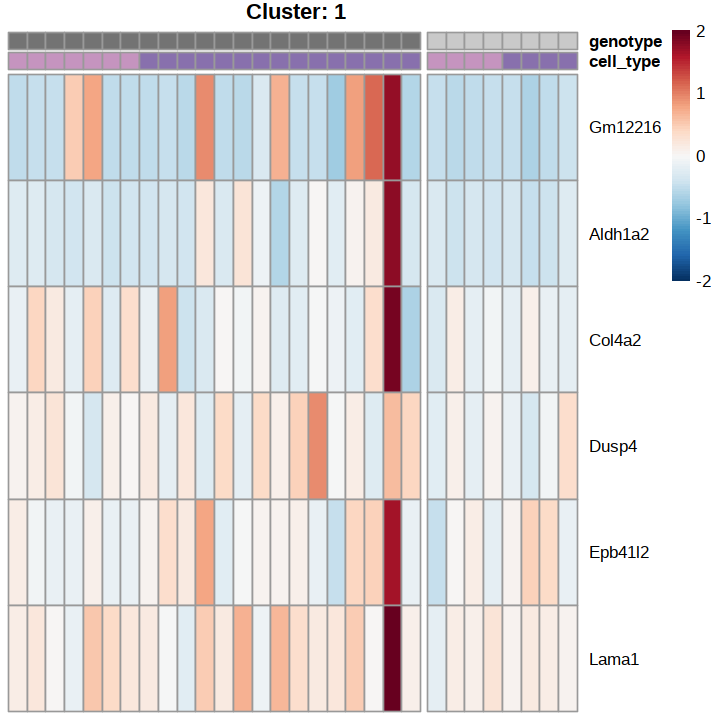

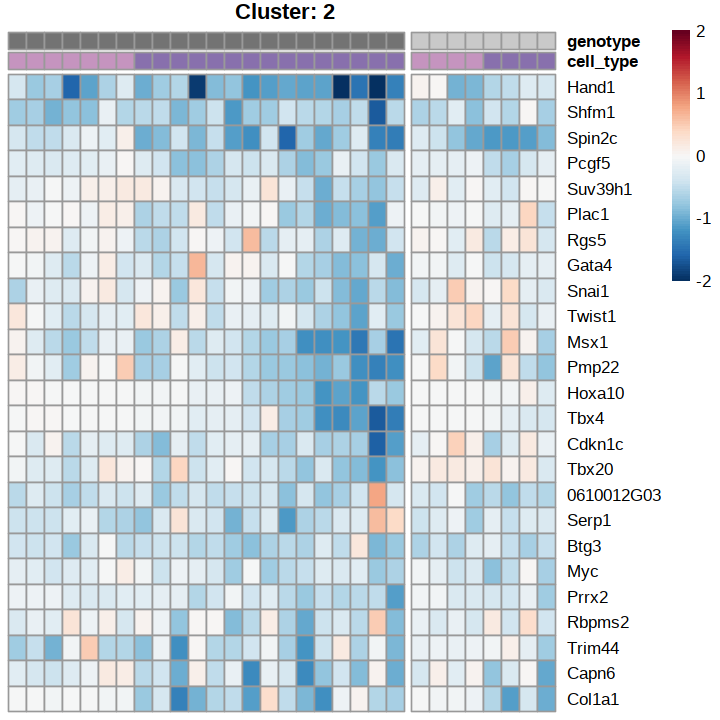

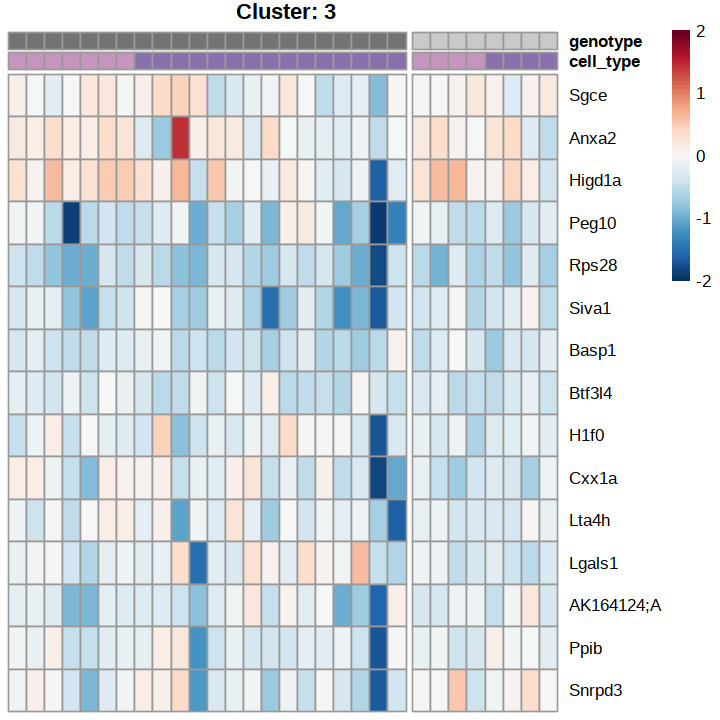

In [24]:
fold_change_threshold <- log2(3)
#f_var = apply(lfc_all_ko,1,min) < -fold_change_threshold
f_var = apply(abs(lfc_all_ko),1,max) >= fold_change_threshold

f_min = apply(cbind(egc_query_all,egc_ref_all),1,max) > 1e-4

genes_selected = rownames(lfc_all)[f_var & f_min]
genes_selected <- setdiff(genes_selected, "Bmp4")
genes_selected = setdiff(genes_selected,bad_genes)

options(repr.plot.width=6, repr.plot.height=6)
shades_rdbu <- colorRampPalette(RColorBrewer::brewer.pal(11,name = "RdBu"))(100)
breaks = seq(-2,2,length.out = 101)

n_cluster = 3
kmeans_genes = tglkmeans::TGL_kmeans(df = lfc_all[genes_selected,],k = n_cluster,id_column = F,seed = 123)
names(kmeans_genes$cluster) = genes_selected

for (cl in 1:n_cluster) {
    
    f = kmeans_genes$cluster == cl     
    lfc_f = lfc_all[genes_selected[f],]
    
    rownames(lfc_f) = substr(x = rownames(lfc_f),start = 1,stop = 10)
    f_ct = df_ann$cell_type == "Allantois"
    df_ann_f = df_ann[!f_ct,]
    pheatmap::pheatmap(mat = lfc_f[,!f_ct],show_colnames = F,show_rownames = T,
                       annotation_legend = F,
                       treeheight_row = 0,
                       gaps_col = c(max(which(df_ann_f$genotype == "tKO")), max(which(df_ann_f$genotype == "Control"))),
                       color = rev(shades_rdbu),
                       breaks = breaks,
                       cluster_cols = F,
                       cluster_rows = T,
                       annotation_col = df_ann_f,
                       annotation_colors = annotation_colors,
                       main = sprintf("Cluster: %s",cl))
}

In [58]:

for (cl in 1:n_cluster) {
    
    f = kmeans_genes$cluster == cl     
    lfc_f = lfc_all[genes_selected[f],]
    
    rownames(lfc_f) = substr(x = rownames(lfc_f),start = 1,stop = 10)
        
    pheatmap::pheatmap(mat = lfc_f,show_colnames = F,show_rownames = T,filename = sprintf("figs/Bmp4_analysis/bmp4_tetraploid_dge_with_allantois_cluster_%d.pdf",cl),
                       annotation_legend = F,
                       treeheight_row = 0,
                       gaps_col = c(max(which(df_ann$genotype == "tKO")), max(which(df_ann$genotype == "Control")),  max(which(df_ann$genotype == "gKO"))),
                       color = rev(shades_rdbu),
                       breaks = breaks,
                       cluster_cols = F,
                       cluster_rows = T,
                       annotation_col = df_ann,
                       annotation_colors = annotation_colors,
                       main = sprintf("Cluster: %s",cl))
}


for (cl in 1:n_cluster) {
    
    f = kmeans_genes$cluster == cl     
    lfc_f = lfc_all[genes_selected[f],]
    
    rownames(lfc_f) = substr(x = rownames(lfc_f),start = 1,stop = 10)
    f_ct = df_ann$cell_type == "Allantois"
    df_ann_f = df_ann[!f_ct,]
    pheatmap::pheatmap(mat = lfc_f[,!f_ct],show_colnames = F,show_rownames = T,filename = sprintf("figs/Bmp4_analysis/bmp4_tetraploid_dge_without_allantois_cluster_%d.pdf",cl),
                       annotation_legend = F,
                       treeheight_row = 0,
                       gaps_col = c(max(which(df_ann_f$genotype == "tKO")), max(which(df_ann_f$genotype == "Control"))),
                       color = rev(shades_rdbu),
                       breaks = breaks,
                       cluster_cols = F,
                       cluster_rows = T,
                       annotation_col = df_ann_f,
                       annotation_colors = annotation_colors,
                       main = sprintf("Cluster: %s",cl))
}

Warning message in max(which(df_ann$genotype == "gKO")):
"no non-missing arguments to max; returning -Inf"
Warning message in max(which(df_ann$genotype == "gKO")):
"no non-missing arguments to max; returning -Inf"
Warning message in max(which(df_ann$genotype == "gKO")):
"no non-missing arguments to max; returning -Inf"
